In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=400 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

flap_interval = int(0.03/0.005)

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = cm_target[-10:-7]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((n_cases,2,flap_interval,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    #total_coords = np.hstack((airfoil_coord, flap_coords))
    total_coords = flap_coords
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,flap_interval))
    flap_right = np.zeros((15,flap_interval))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/flap_interval, -h[i], flap_interval).reshape((-1,1))
        yRight = np.linspace(-h[i]/flap_interval, -h[i], flap_interval).reshape((-1,1))
        xLeft = 0.5*np.ones((flap_interval,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((flap_interval,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,flap_interval))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    flap_coords2[:2000,flap_interval:] = 0
    flap_coords2[2000:4000, flap_interval*2:] = 0
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - airfoil coordinates:  (6000, 50)
Dimension - coord with flaps:  (6000, 6)
Dimension - total coordinates:  (6000, 6)
Dimension - x_time:  (3000, 1)
Dimension - x_coordinates:  (3000, 2, 6, 1)
Dimension - y:  (3000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [24]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,flap_interval,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [25]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 6, 1)]    0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 6, 400)    2000        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 3, 400)    0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 1200)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20230103\\3Case(131415)(l2)(flapOnly0.005)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.005)_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
10/10 [==============================] - ETA: 0s - loss: 0.1683 - rmse: 0.4101
Epoch 1: val_loss improved from inf to 0.15835, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.005)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.005)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 12s 68ms/step - loss: 0.1683 - rmse: 0.4101 - val_loss: 0.1584 - val_rmse: 0.3978 - lr: 1.0000e-04
Epoch 2/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.1482 - rmse: 0.3847
Epoch 2: val_loss improved from 0.15835 to 0.12079, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.005)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.005)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.1403 - rmse: 0.3744 - val_loss: 0.1208 - val_rmse: 0.3473 - lr: 1.0000e-04
Epoch 3/10000
 6/10 [=================>..........

 6/10 [=================>............] - ETA: 0s - loss: 0.0322 - rmse: 0.1790
Epoch 18: val_loss improved from 0.03517 to 0.03033, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.005)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.005)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 27ms/step - loss: 0.0311 - rmse: 0.1759 - val_loss: 0.0303 - val_rmse: 0.1737 - lr: 1.0000e-04
Epoch 19/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0290 - rmse: 0.1700
Epoch 19: val_loss improved from 0.03033 to 0.02551, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.005)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.005)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.0275 - rmse: 0.1655 - val_loss: 0.0255 - val_rmse: 0.1593 - lr: 1.0000e-04
Epoch 20/10000
 6/10 [=================>............] - E

 6/10 [=================>............] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 35: val_loss improved from 0.00318 to 0.00304, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.005)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.005)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 24ms/step - loss: 0.0030 - rmse: 0.0535 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-04
Epoch 36/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0030 - rmse: 0.0531
Epoch 36: val_loss improved from 0.00304 to 0.00276, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.005)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.005)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.0029 - rmse: 0.0524 - val_loss: 0.0028 - val_rmse: 0.0512 - lr: 1.0000e-04
Epoch 37/10000
 6/10 [=================>............] - E

10/10 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0400 - val_loss: 0.0015 - val_rmse: 0.0370 - lr: 1.0000e-04
Epoch 55/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0017 - rmse: 0.0395
Epoch 55: val_loss did not improve from 0.00151
10/10 [==============================] - 0s 13ms/step - loss: 0.0017 - rmse: 0.0392 - val_loss: 0.0017 - val_rmse: 0.0394 - lr: 1.0000e-04
Epoch 56/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0016 - rmse: 0.0382
Epoch 56: val_loss did not improve from 0.00151
10/10 [==============================] - 0s 13ms/step - loss: 0.0016 - rmse: 0.0380 - val_loss: 0.0015 - val_rmse: 0.0374 - lr: 1.0000e-04
Epoch 57/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0017 - rmse: 0.0395
Epoch 57: val_loss did not improve from 0.00151
10/10 [==============================] - 0s 13ms/step - loss: 0.0017 - rmse: 0.0392 - val_loss: 0.0015 - val_rmse: 0.0374 - lr: 1.0000e-04
Epoch 58/10000
 7/

Epoch 79/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 79: val_loss did not improve from 0.00124
10/10 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0013 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 80/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0014 - rmse: 0.0352
Epoch 80: val_loss improved from 0.00124 to 0.00114, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.005)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.005)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0350 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 81/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0326
Epoch 81: val_loss did not improve from 0.00114
10/10 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0327 - val_loss: 0.

 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0305    
Epoch 103: val_loss did not improve from 0.00103
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0306 - val_loss: 0.0012 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 104/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0314    
Epoch 104: val_loss did not improve from 0.00103
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0312 - val_loss: 0.0011 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 105/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0322
Epoch 105: val_loss did not improve from 0.00103
10/10 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0321 - val_loss: 0.0013 - val_rmse: 0.0338 - lr: 1.0000e-04
Epoch 106/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0322
Epoch 106: val_loss improved from 0.00103 to 0.00103, saving mod

Epoch 129/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5979e-04 - rmse: 0.0288
Epoch 129: val_loss did not improve from 0.00094
10/10 [==============================] - 0s 12ms/step - loss: 9.8065e-04 - rmse: 0.0292 - val_loss: 9.5494e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 130/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9995e-04 - rmse: 0.0295
Epoch 130: val_loss did not improve from 0.00094
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0299 - val_loss: 0.0012 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 131/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0305    
Epoch 131: val_loss did not improve from 0.00094
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0305 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 132/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0916e-04 - rmse: 0.0279
Epoch 132: val_loss did not impr

 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0299
Epoch 155: val_loss did not improve from 0.00092
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0297 - val_loss: 9.5270e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 156/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7184e-04 - rmse: 0.0291
Epoch 156: val_loss did not improve from 0.00092
10/10 [==============================] - 0s 13ms/step - loss: 9.6104e-04 - rmse: 0.0289 - val_loss: 9.7361e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 157/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0298    
Epoch 157: val_loss did not improve from 0.00092
10/10 [==============================] - 0s 13ms/step - loss: 9.7806e-04 - rmse: 0.0292 - val_loss: 9.8608e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 158/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7561e-04 - rmse: 0.0292
Epoch 158: val_loss did not improve from

Epoch 183/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0298
Epoch 183: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 9.6836e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 184/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8715e-04 - rmse: 0.0294
Epoch 184: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 9.7950e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 185/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0306
Epoch 185: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0304 - val_loss: 9.5223e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 186/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8743e-04 - rmse: 0.0295
Epoch 186: val_loss did not improve 

Epoch 211/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9151e-04 - rmse: 0.0296
Epoch 211: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 12ms/step - loss: 9.6855e-04 - rmse: 0.0292 - val_loss: 9.9887e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 212/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2160e-04 - rmse: 0.0284
Epoch 212: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 12ms/step - loss: 9.1058e-04 - rmse: 0.0282 - val_loss: 9.9407e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 213/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6199e-04 - rmse: 0.0291
Epoch 213: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 9.5798e-04 - rmse: 0.0290 - val_loss: 9.0683e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 214/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4108e-04 - rmse: 0.0287
Epoch 214: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0300    
Epoch 239: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 9.7708e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 240/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0566e-04 - rmse: 0.0282
Epoch 240: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 9.6054e-04 - rmse: 0.0291 - val_loss: 0.0012 - val_rmse: 0.0328 - lr: 1.0000e-04
Epoch 241/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0323
Epoch 241: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0012 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 242/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0300    
Epoch 242: val_loss did not improve from 0.00089
10/

Epoch 267/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6325e-04 - rmse: 0.0275
Epoch 267: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 12ms/step - loss: 9.2710e-04 - rmse: 0.0286 - val_loss: 0.0010 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 268/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4991e-04 - rmse: 0.0290
Epoch 268: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 9.7011e-04 - rmse: 0.0294 - val_loss: 9.0866e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 269/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2358e-04 - rmse: 0.0286
Epoch 269: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 13ms/step - loss: 9.6262e-04 - rmse: 0.0292 - val_loss: 0.0010 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 270/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6485e-04 - rmse: 0.0293
Epoch 270: val_loss did 

Epoch 294/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.4213e-04 - rmse: 0.0289
Epoch 294: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 14ms/step - loss: 9.6141e-04 - rmse: 0.0293 - val_loss: 9.1638e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 295/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2499e-04 - rmse: 0.0287
Epoch 295: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.3134e-04 - rmse: 0.0288 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 296/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3641e-04 - rmse: 0.0289
Epoch 296: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.7224e-04 - rmse: 0.0295 - val_loss: 0.0010 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 297/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7297e-04 - rmse: 0.0295
Epoch 297: val_loss did 

Epoch 322/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0311
Epoch 322: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 9.9833e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 323/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2894e-04 - rmse: 0.0288
Epoch 323: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.5391e-04 - rmse: 0.0292 - val_loss: 9.0346e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 324/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9942e-04 - rmse: 0.0283
Epoch 324: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.0969e-04 - rmse: 0.0284 - val_loss: 9.7193e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 325/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7952e-04 - rmse: 0.0297
Epoch 325: val_loss did 

10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 9.3991e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 350/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0310
Epoch 350: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 351/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0311
Epoch 351: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 352/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9204e-04 - rmse: 0.0299
Epoch 352: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.7142e-04 - rmse: 0.0296 - val_loss: 0.0010 - val_rmse: 0.0305 - lr: 1.0000e-04


Epoch 377/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7154e-04 - rmse: 0.0279
Epoch 377: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.1065e-04 - rmse: 0.0286 - val_loss: 8.9548e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 378/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4383e-04 - rmse: 0.0291
Epoch 378: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 12ms/step - loss: 9.9545e-04 - rmse: 0.0300 - val_loss: 9.2370e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 379/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7122e-04 - rmse: 0.0296
Epoch 379: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 13ms/step - loss: 9.7760e-04 - rmse: 0.0297 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 380/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 380: val_loss did 

 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0323    
Epoch 404: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0011 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 405/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 405: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 9.1216e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 406/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4925e-04 - rmse: 0.0293
Epoch 406: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 13ms/step - loss: 9.3094e-04 - rmse: 0.0290 - val_loss: 8.8970e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 407/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0080e-04 - rmse: 0.0284
Epoch 407: val_loss did not improve from 0.00086

Epoch 432/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0705e-04 - rmse: 0.0286
Epoch 432: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 13ms/step - loss: 9.3175e-04 - rmse: 0.0290 - val_loss: 8.8307e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 433/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8999e-04 - rmse: 0.0283
Epoch 433: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 13ms/step - loss: 8.6505e-04 - rmse: 0.0279 - val_loss: 9.4382e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 434/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7252e-04 - rmse: 0.0297
Epoch 434: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0303 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 435/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0311
Epoch 435: val_loss did not 

 7/10 [====================>.........] - ETA: 0s - loss: 9.2607e-04 - rmse: 0.0290
Epoch 460: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 13ms/step - loss: 9.2730e-04 - rmse: 0.0290 - val_loss: 8.8035e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 461/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7620e-04 - rmse: 0.0281
Epoch 461: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 12ms/step - loss: 8.5992e-04 - rmse: 0.0278 - val_loss: 9.3943e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 462/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4214e-04 - rmse: 0.0275
Epoch 462: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 13ms/step - loss: 9.0436e-04 - rmse: 0.0286 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 463/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3759e-04 - rmse: 0.0292
Epoch 463: val_loss did not improve 

 7/10 [====================>.........] - ETA: 0s - loss: 8.8380e-04 - rmse: 0.0283
Epoch 488: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 13ms/step - loss: 8.4353e-04 - rmse: 0.0275 - val_loss: 8.7009e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 489/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6675e-04 - rmse: 0.0297
Epoch 489: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 13ms/step - loss: 9.5979e-04 - rmse: 0.0296 - val_loss: 9.3551e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 490/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8997e-04 - rmse: 0.0284
Epoch 490: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 13ms/step - loss: 8.9028e-04 - rmse: 0.0284 - val_loss: 9.1823e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 491/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7368e-04 - rmse: 0.0281
Epoch 491: val_loss did not impr

 7/10 [====================>.........] - ETA: 0s - loss: 9.5349e-04 - rmse: 0.0295
Epoch 515: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0303 - val_loss: 8.6044e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 516/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0304    
Epoch 516: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 13ms/step - loss: 9.5114e-04 - rmse: 0.0295 - val_loss: 9.0480e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 517/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0308    
Epoch 517: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 518/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6482e-04 - rmse: 0.0297
Epoch 518: val_loss did not improve from 0.0

 7/10 [====================>.........] - ETA: 0s - loss: 8.4956e-04 - rmse: 0.0277
Epoch 542: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.5197e-04 - rmse: 0.0278 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 543/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6596e-04 - rmse: 0.0297
Epoch 543: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.3016e-04 - rmse: 0.0291 - val_loss: 8.7936e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 544/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9395e-04 - rmse: 0.0285
Epoch 544: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.9236e-04 - rmse: 0.0285 - val_loss: 9.3427e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 545/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8739e-04 - rmse: 0.0284
Epoch 545: val_loss did not improve 

Epoch 570/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6234e-04 - rmse: 0.0280
Epoch 570: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.6865e-04 - rmse: 0.0281 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 571/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0612e-04 - rmse: 0.0287
Epoch 571: val_loss improved from 0.00084 to 0.00084, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.005)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.005)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 28ms/step - loss: 9.3402e-04 - rmse: 0.0292 - val_loss: 8.4133e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 572/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7286e-04 - rmse: 0.0282
Epoch 572: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.5168

 7/10 [====================>.........] - ETA: 0s - loss: 8.7015e-04 - rmse: 0.0281
Epoch 597: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 8.7530e-04 - rmse: 0.0282 - val_loss: 9.0755e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 598/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4370e-04 - rmse: 0.0294
Epoch 598: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.1257e-04 - rmse: 0.0289 - val_loss: 9.2415e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 599/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1470e-04 - rmse: 0.0289
Epoch 599: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.7910e-04 - rmse: 0.0300 - val_loss: 9.0800e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 600/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2109e-04 - rmse: 0.0290
Epoch 600: val_loss did not impr

 7/10 [====================>.........] - ETA: 0s - loss: 9.1817e-04 - rmse: 0.0290
Epoch 624: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 9.2449e-04 - rmse: 0.0291 - val_loss: 9.0735e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 625/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7892e-04 - rmse: 0.0283
Epoch 625: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 8.8244e-04 - rmse: 0.0284 - val_loss: 9.2178e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 626/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8967e-04 - rmse: 0.0285
Epoch 626: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.2499e-04 - rmse: 0.0291 - val_loss: 9.5537e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 627/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6862e-04 - rmse: 0.0281
Epoch 627: val_loss did not impr

Epoch 652/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5233e-04 - rmse: 0.0296
Epoch 652: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.6191e-04 - rmse: 0.0298 - val_loss: 8.5762e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 653/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7275e-04 - rmse: 0.0300
Epoch 653: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.4009e-04 - rmse: 0.0294 - val_loss: 9.2936e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 654/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0305    
Epoch 654: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 9.6451e-04 - rmse: 0.0298 - val_loss: 8.3974e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 655/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0158e-04 - rmse: 0.0287
Epoch 655: val_l

Epoch 680/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2661e-04 - rmse: 0.0292
Epoch 680: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.9855e-04 - rmse: 0.0287 - val_loss: 9.0189e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 681/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2531e-04 - rmse: 0.0292
Epoch 681: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.0395e-04 - rmse: 0.0288 - val_loss: 8.8034e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 682/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8259e-04 - rmse: 0.0284
Epoch 682: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.1297e-04 - rmse: 0.0290 - val_loss: 8.7043e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 683/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5116e-04 - rmse: 0.0296
Epoch 683: val_l

Epoch 708/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3665e-04 - rmse: 0.0276
Epoch 708: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.6605e-04 - rmse: 0.0282 - val_loss: 8.5836e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 709/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5224e-04 - rmse: 0.0279
Epoch 709: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.7261e-04 - rmse: 0.0283 - val_loss: 8.4496e-04 - val_rmse: 0.0278 - lr: 5.0000e-05
Epoch 710/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9838e-04 - rmse: 0.0287
Epoch 710: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.6963e-04 - rmse: 0.0282 - val_loss: 8.8704e-04 - val_rmse: 0.0285 - lr: 5.0000e-05
Epoch 711/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9030e-04 - rmse: 0.0286
Epoch 711: val_l

Epoch 736/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7439e-04 - rmse: 0.0283
Epoch 736: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 8.5009e-04 - rmse: 0.0279 - val_loss: 9.3103e-04 - val_rmse: 0.0293 - lr: 5.0000e-05
Epoch 737/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9687e-04 - rmse: 0.0287
Epoch 737: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.7310e-04 - rmse: 0.0283 - val_loss: 9.0437e-04 - val_rmse: 0.0288 - lr: 5.0000e-05
Epoch 738/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8724e-04 - rmse: 0.0285
Epoch 738: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 8.7529e-04 - rmse: 0.0283 - val_loss: 8.6171e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 739/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9954e-04 - rmse: 0.0304
Epoch 739: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 8.7901e-04 - rmse: 0.0284
Epoch 763: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.9938e-04 - rmse: 0.0288 - val_loss: 8.8281e-04 - val_rmse: 0.0285 - lr: 5.0000e-05
Epoch 764/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3779e-04 - rmse: 0.0277
Epoch 764: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 8.3753e-04 - rmse: 0.0277 - val_loss: 9.0481e-04 - val_rmse: 0.0289 - lr: 5.0000e-05
Epoch 765/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7304e-04 - rmse: 0.0283
Epoch 765: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.6874e-04 - rmse: 0.0282 - val_loss: 9.1408e-04 - val_rmse: 0.0290 - lr: 5.0000e-05
Epoch 766/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8407e-04 - rmse: 0.0285
Epoch 766: val_loss did not impr

 7/10 [====================>.........] - ETA: 0s - loss: 8.5603e-04 - rmse: 0.0280
Epoch 790: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.3786e-04 - rmse: 0.0277 - val_loss: 9.1591e-04 - val_rmse: 0.0291 - lr: 5.0000e-05
Epoch 791/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8374e-04 - rmse: 0.0285
Epoch 791: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 9.0335e-04 - rmse: 0.0288 - val_loss: 8.8409e-04 - val_rmse: 0.0285 - lr: 5.0000e-05
Epoch 792/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5545e-04 - rmse: 0.0280
Epoch 792: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 8.5366e-04 - rmse: 0.0280 - val_loss: 8.6314e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 793/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7038e-04 - rmse: 0.0283
Epoch 793: val_loss did not impr

Epoch 818/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5831e-04 - rmse: 0.0281
Epoch 818: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.4541e-04 - rmse: 0.0278 - val_loss: 8.4732e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 819/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2797e-04 - rmse: 0.0293
Epoch 819: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 9.2987e-04 - rmse: 0.0293 - val_loss: 8.9630e-04 - val_rmse: 0.0287 - lr: 5.0000e-05
Epoch 820/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3592e-04 - rmse: 0.0277
Epoch 820: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.5743e-04 - rmse: 0.0280 - val_loss: 9.4739e-04 - val_rmse: 0.0296 - lr: 5.0000e-05
Epoch 821/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3920e-04 - rmse: 0.0277
Epoch 821: val_l

Epoch 846/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4209e-04 - rmse: 0.0278
Epoch 846: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.4073e-04 - rmse: 0.0277 - val_loss: 8.9804e-04 - val_rmse: 0.0288 - lr: 5.0000e-05
Epoch 847/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9812e-04 - rmse: 0.0288
Epoch 847: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.8737e-04 - rmse: 0.0286 - val_loss: 9.2466e-04 - val_rmse: 0.0292 - lr: 5.0000e-05
Epoch 848/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6401e-04 - rmse: 0.0282
Epoch 848: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 8.4224e-04 - rmse: 0.0278 - val_loss: 8.7939e-04 - val_rmse: 0.0284 - lr: 5.0000e-05
Epoch 849/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8923e-04 - rmse: 0.0286
Epoch 849: val_l

Epoch 874/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1330e-04 - rmse: 0.0290
Epoch 874: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.9085e-04 - rmse: 0.0286 - val_loss: 9.1878e-04 - val_rmse: 0.0291 - lr: 5.0000e-05
Epoch 875/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8871e-04 - rmse: 0.0286
Epoch 875: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 9.0352e-04 - rmse: 0.0289 - val_loss: 8.8765e-04 - val_rmse: 0.0286 - lr: 5.0000e-05
Epoch 876/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1356e-04 - rmse: 0.0273
Epoch 876: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 13ms/step - loss: 8.3506e-04 - rmse: 0.0277 - val_loss: 8.8073e-04 - val_rmse: 0.0285 - lr: 5.0000e-05
Epoch 877/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2330e-04 - rmse: 0.0274
Epoch 877: val_l

10/10 [==============================] - 0s 13ms/step - loss: 8.9550e-04 - rmse: 0.0287 - val_loss: 9.9514e-04 - val_rmse: 0.0304 - lr: 5.0000e-05
Epoch 901/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0591e-04 - rmse: 0.0289
Epoch 901: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 9.2506e-04 - rmse: 0.0292 - val_loss: 8.5035e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 902/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8664e-04 - rmse: 0.0286
Epoch 902: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.2573e-04 - rmse: 0.0275 - val_loss: 8.7815e-04 - val_rmse: 0.0284 - lr: 5.0000e-05
Epoch 903/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9100e-04 - rmse: 0.0287
Epoch 903: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.8174e-04 - rmse: 0.0285 - val_loss: 9.4765e-04 - va

 7/10 [====================>.........] - ETA: 0s - loss: 9.0916e-04 - rmse: 0.0290
Epoch 928: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.8684e-04 - rmse: 0.0286 - val_loss: 8.5055e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 929/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1211e-04 - rmse: 0.0290
Epoch 929: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.7727e-04 - rmse: 0.0284 - val_loss: 8.9961e-04 - val_rmse: 0.0288 - lr: 5.0000e-05
Epoch 930/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0150e-04 - rmse: 0.0288
Epoch 930: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 9.1375e-04 - rmse: 0.0291 - val_loss: 9.1647e-04 - val_rmse: 0.0291 - lr: 5.0000e-05
Epoch 931/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3362e-04 - rmse: 0.0276
Epoch 931: val_loss did not impr

Epoch 956/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6096e-04 - rmse: 0.0281
Epoch 956: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.5856e-04 - rmse: 0.0281 - val_loss: 9.6646e-04 - val_rmse: 0.0300 - lr: 5.0000e-05
Epoch 957/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6486e-04 - rmse: 0.0282
Epoch 957: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.7276e-04 - rmse: 0.0284 - val_loss: 9.0585e-04 - val_rmse: 0.0289 - lr: 5.0000e-05
Epoch 958/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6207e-04 - rmse: 0.0282
Epoch 958: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.5556e-04 - rmse: 0.0280 - val_loss: 8.8116e-04 - val_rmse: 0.0285 - lr: 5.0000e-05
Epoch 959/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3489e-04 - rmse: 0.0277
Epoch 959: val_l

Epoch 983/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4526e-04 - rmse: 0.0279
Epoch 983: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 15ms/step - loss: 8.3268e-04 - rmse: 0.0276 - val_loss: 8.4591e-04 - val_rmse: 0.0279 - lr: 2.5000e-05
Epoch 984/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7768e-04 - rmse: 0.0284
Epoch 984: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 15ms/step - loss: 8.4056e-04 - rmse: 0.0278 - val_loss: 8.5888e-04 - val_rmse: 0.0281 - lr: 2.5000e-05
Epoch 985/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1393e-04 - rmse: 0.0291
Epoch 985: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 16ms/step - loss: 8.8687e-04 - rmse: 0.0286 - val_loss: 9.1992e-04 - val_rmse: 0.0292 - lr: 2.5000e-05
Epoch 986/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.5515e-04 - rmse: 0.0280
Epoch 986: val_l

Epoch 1011/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1236e-04 - rmse: 0.0273
Epoch 1011: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.5072e-04 - rmse: 0.0280 - val_loss: 8.4709e-04 - val_rmse: 0.0279 - lr: 2.5000e-05
Epoch 1012/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6775e-04 - rmse: 0.0283
Epoch 1012: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.3650e-04 - rmse: 0.0277 - val_loss: 8.7226e-04 - val_rmse: 0.0284 - lr: 2.5000e-05
Epoch 1013/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5807e-04 - rmse: 0.0281
Epoch 1013: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.3873e-04 - rmse: 0.0278 - val_loss: 8.6320e-04 - val_rmse: 0.0282 - lr: 2.5000e-05
Epoch 1014/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6590e-04 - rmse: 0.0282
Epoch 101

Epoch 1039/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6598e-04 - rmse: 0.0282
Epoch 1039: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.6132e-04 - rmse: 0.0282 - val_loss: 8.4872e-04 - val_rmse: 0.0279 - lr: 2.5000e-05
Epoch 1040/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8557e-04 - rmse: 0.0286
Epoch 1040: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 14ms/step - loss: 8.3911e-04 - rmse: 0.0278 - val_loss: 8.8739e-04 - val_rmse: 0.0286 - lr: 2.5000e-05
Epoch 1041/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8690e-04 - rmse: 0.0286
Epoch 1041: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 14ms/step - loss: 8.9335e-04 - rmse: 0.0287 - val_loss: 9.2184e-04 - val_rmse: 0.0292 - lr: 2.5000e-05
Epoch 1042/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4748e-04 - rmse: 0.0279
Epoch 104

Epoch 1067/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5121e-04 - rmse: 0.0280
Epoch 1067: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.3433e-04 - rmse: 0.0277 - val_loss: 8.9801e-04 - val_rmse: 0.0288 - lr: 2.5000e-05
Epoch 1068/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9127e-04 - rmse: 0.0287
Epoch 1068: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.6974e-04 - rmse: 0.0283 - val_loss: 8.5458e-04 - val_rmse: 0.0280 - lr: 2.5000e-05
Epoch 1069/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.9624e-04 - rmse: 0.0270
Epoch 1069: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.3362e-04 - rmse: 0.0277 - val_loss: 8.6029e-04 - val_rmse: 0.0282 - lr: 2.5000e-05
Epoch 1070/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8195e-04 - rmse: 0.0285
Epoch 107

Epoch 1095/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4877e-04 - rmse: 0.0279
Epoch 1095: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.4939e-04 - rmse: 0.0280 - val_loss: 8.8786e-04 - val_rmse: 0.0286 - lr: 2.5000e-05
Epoch 1096/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7795e-04 - rmse: 0.0285
Epoch 1096: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.6744e-04 - rmse: 0.0283 - val_loss: 8.8056e-04 - val_rmse: 0.0285 - lr: 2.5000e-05
Epoch 1097/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4466e-04 - rmse: 0.0279
Epoch 1097: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 9.0183e-04 - rmse: 0.0289 - val_loss: 8.7039e-04 - val_rmse: 0.0283 - lr: 2.5000e-05
Epoch 1098/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.9469e-04 - rmse: 0.0270
Epoch 109

Epoch 1123/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9787e-04 - rmse: 0.0288
Epoch 1123: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.7965e-04 - rmse: 0.0285 - val_loss: 8.6423e-04 - val_rmse: 0.0282 - lr: 2.5000e-05
Epoch 1124/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3551e-04 - rmse: 0.0277
Epoch 1124: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.3238e-04 - rmse: 0.0277 - val_loss: 8.9137e-04 - val_rmse: 0.0287 - lr: 2.5000e-05
Epoch 1125/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7823e-04 - rmse: 0.0285
Epoch 1125: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.4921e-04 - rmse: 0.0280 - val_loss: 8.6925e-04 - val_rmse: 0.0283 - lr: 2.5000e-05
Epoch 1126/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1480e-04 - rmse: 0.0273
Epoch 112

Epoch 1151/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4545e-04 - rmse: 0.0279
Epoch 1151: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.3183e-04 - rmse: 0.0277 - val_loss: 8.7875e-04 - val_rmse: 0.0285 - lr: 2.5000e-05
Epoch 1152/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5538e-04 - rmse: 0.0281
Epoch 1152: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.6014e-04 - rmse: 0.0282 - val_loss: 8.4646e-04 - val_rmse: 0.0279 - lr: 2.5000e-05
Epoch 1153/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3721e-04 - rmse: 0.0277
Epoch 1153: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.3509e-04 - rmse: 0.0277 - val_loss: 9.4000e-04 - val_rmse: 0.0295 - lr: 2.5000e-05
Epoch 1154/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0087e-04 - rmse: 0.0289
Epoch 115

Epoch 1179/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3373e-04 - rmse: 0.0294
Epoch 1179: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 8.6712e-04 - rmse: 0.0283 - val_loss: 9.0569e-04 - val_rmse: 0.0290 - lr: 2.5000e-05
Epoch 1180/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1473e-04 - rmse: 0.0291Restoring model weights from the end of the best epoch: 780.

Epoch 1180: val_loss did not improve from 0.00083

Epoch 1180: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
10/10 [==============================] - 0s 14ms/step - loss: 8.6633e-04 - rmse: 0.0283 - val_loss: 8.3009e-04 - val_rmse: 0.0276 - lr: 2.5000e-05
Epoch 1180: early stopping


In [31]:
time = end - start
print("Training time:", time)

Training time: 0:02:52.448462


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230103_AeroCNN1_3Case(131415)(l2)(flapOnly0.005)_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

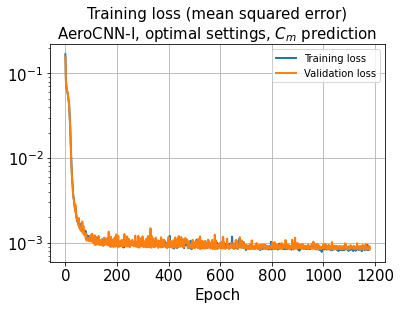

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

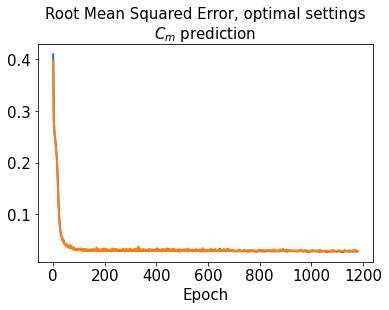

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

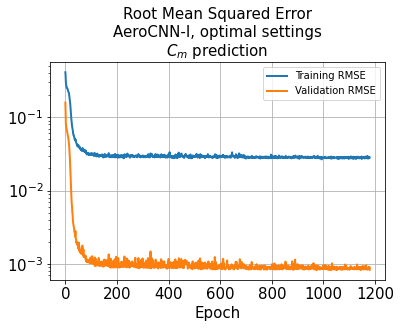

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

66/66 [==============================] - 1s 5ms/step - loss: 8.9473e-04 - rmse: 0.0287


In [37]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

19/19 [==============================] - 0s 7ms/step - loss: 8.3574e-04 - rmse: 0.0276


In [38]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

10/10 [==============================] - 0s 8ms/step - loss: 9.9756e-04 - rmse: 0.0304


In [39]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

10/10 [==============================] - 0s 3ms/step


In [40]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.06627580705457489
2.6093887400191127


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.06290699565044419
2.477207273304469


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.06765647565625002
2.610321698948106


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20230103"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.005)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

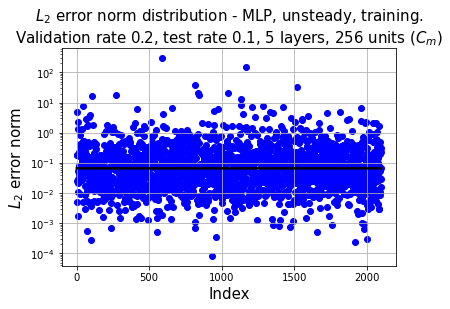

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

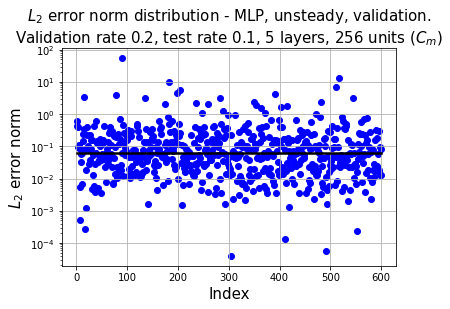

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

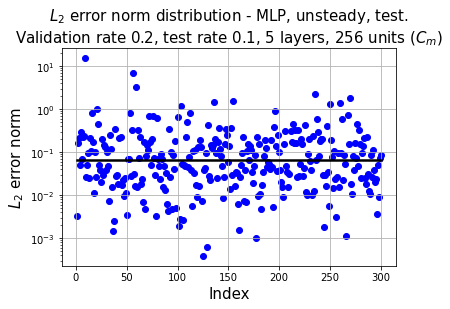

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict([x_time, x_coord])

94/94 [==============================] - 0s 2ms/step


In [64]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [65]:
max(predicted)

array([0.95280445], dtype=float32)

In [66]:
print(l2_error(predicted, y))

0.06575434839060468


In [67]:
cm[2000]

array([0.00682824])

In [68]:
cm[1000]

array([0.0014248])

In [69]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [70]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [71]:
t

array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [0.997],
       [0.998],
       [0.999]])

In [72]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [73]:
len(predicted[index_train])

2101

In [74]:
len(predicted[index_val])

600

In [75]:
len(predicted[index_test])

301

In [76]:
x_time += 10

L2 error of Cm: 0.0876


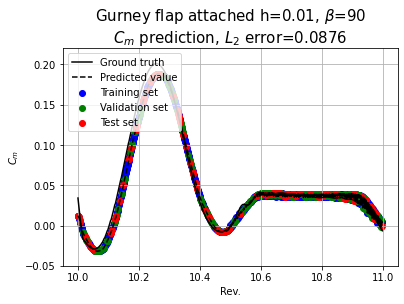

L2 error of Cm: 0.0187


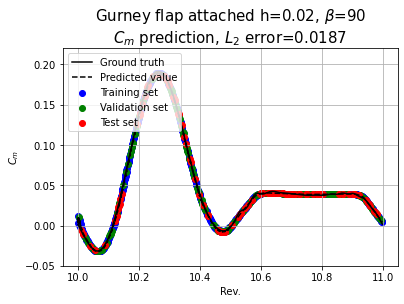

L2 error of Cm: 0.0693


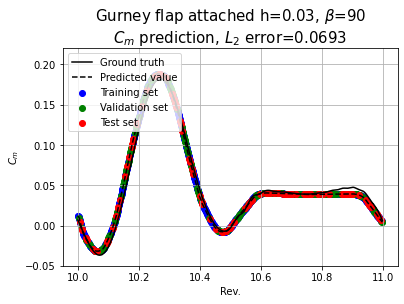

In [77]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [78]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    plt.xlim([10.17, 10.23])
    plt.ylim([0.11, 0.15])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0876


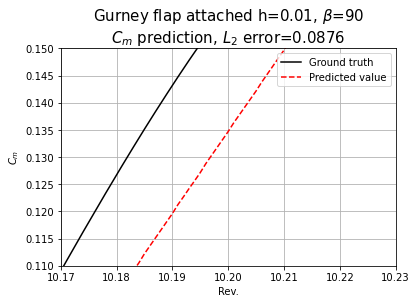

L2 error of Cm: 0.0187


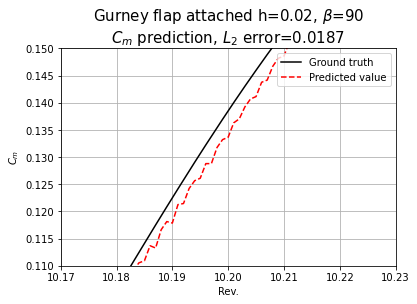

L2 error of Cm: 0.0693


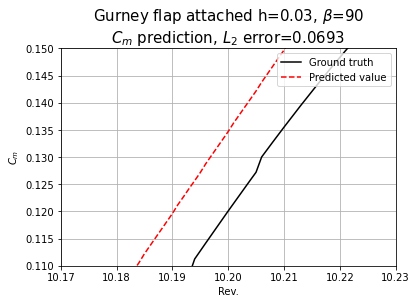

In [79]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0876


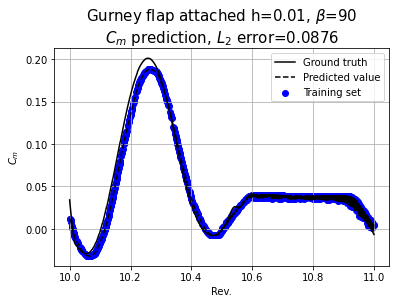

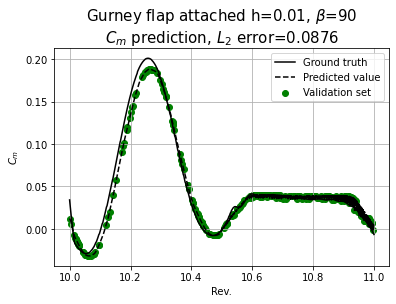

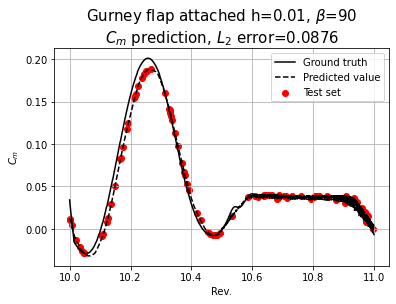

L2 error of Cm: 0.0187


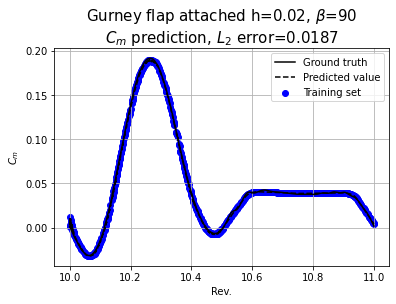

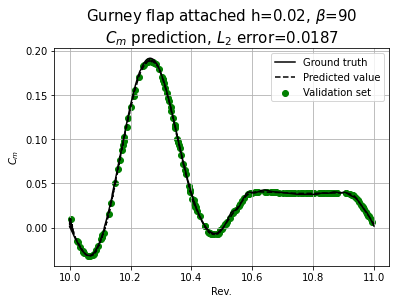

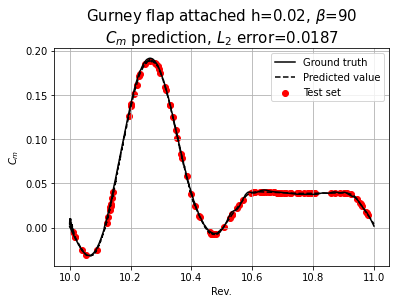

L2 error of Cm: 0.0693


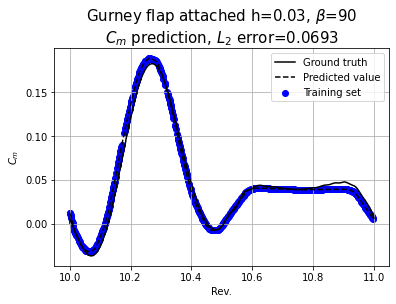

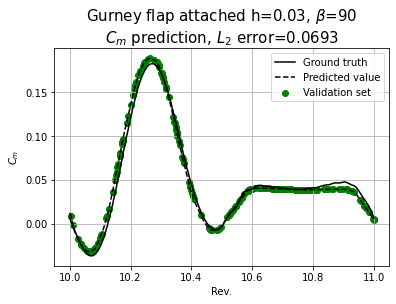

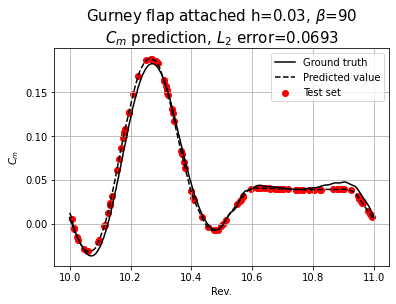

In [81]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    # Cm graph plot
    ## Training dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()